In [ ]:
%matplotlib inline

In [ ]:
# 単変量LSTMでsin波予測 (チュートリアルとして規則性のあるデータを予測)

In [ ]:
# データ

In [64]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# sin波生成
def sin(length=100, curve=4):
    x = np.arange(0, length)
    return np.sin((curve * np.pi) * x / length)

In [ ]:
plt.plot(sin())
plt.show()

In [ ]:
# ノイズ付きsin波
def noised_sin(length=100, curve=4, noise_rate=0.1, low=-1.0, high=1.0):
    x = sin(length=length, curve=curve)
    noise = noise_rate * np.random.uniform(low=low, high=high, size=len(x))
    return x + noise

In [ ]:
plt.plot(noised_sin())
plt.show()

In [63]:
# 学習用時系列データとして整形
def create_reccurent_dataset(vector_data, step=25):
    data, target = [], []
    for i in range(len(vector_data) - step):
        data.append(vector_data[i:(i + step)])
        target.append(vector_data[i + step])
    reshape_data = np.array(data).reshape(len(data), step, 1)
    reshape_label = np.array(target).reshape(len(data), 1)
    return reshape_data, reshape_label

In [ ]:
# 形状と内容の確認
train_data, train_label = create_reccurent_dataset([1,2,3,4,5,6,7,8,9], 3)

In [ ]:
# 学習データ、stepで区切った時系列データ、3次元配列
# なぜ3次元なのか = 他にも気温、湿度、曜日など予測に役立ちそうなデータを入れられる。
# 今回は1個のデータのみ
# (学習データ総数, 1学習の時系列数(ステップ数), 特徴量)
print(train_data.shape)
print(train_data)

In [ ]:
# 答えラベル、次に来るべき値、2次元配列
print(train_label.shape)
print(train_label)

In [ ]:
# ノイズ付きsin波予測
data = noised_sin(length=100, curve=4, noise_rate=0.1)
train_data, train_label = create_reccurent_dataset(data, step=25)

In [ ]:
train_data.shape

In [ ]:
train_label.shape

In [ ]:
# モデル構築

In [ ]:
# 時系列(長短期記憶)学習モデルの種類
# RNN, LSTM, [QRNN](https://qiita.com/icoxfog417/items/d77912e10a7c60ae680e)...他
# LSTM
#   LSTM(1D) 例: 1次元の時系列データを入力として利用する
#   ConvLSTM2D 例: 動画を時系列データを入力として利用する
#   ConvLSTM3D 例: 空間の変化を時系列データを入力として利用する

In [ ]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, LSTM
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping

In [ ]:
step_count = 25 # 1つの学習データのStep数(今回は25)
feature_count = 1 # 特徴量 今回の学習するデータは1個のみ
hidden_unit_count = 300 # 中間層の数だと思う (公式は:出力の次元数?) https://keras.io/ja/layers/recurrent/#lstm

In [ ]:
model = Sequential()
model.add(LSTM(hidden_unit_count, batch_input_shape=(None, step_count, feature_count), return_sequences=False))
model.add(Dense(1))
model.add(Activation('linear'))
optimizer = Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [ ]:
model.output_shape

In [ ]:
# 早期終了 過学習抑制、打ち切る手法 過学習(Over fitting)に陥ることを避けつつ、簡単にエポック数を考える手間を減らすことができる
# 30~50epochsくらいで十分学習できたと判断して終了するはず
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)

In [ ]:
# トレーニング
model.fit(
    train_data, train_label,
    batch_size=300,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stopping]
)

In [ ]:
# 推論、検証
predictions = model.predict(train_data)

In [ ]:
plt.figure()
plt.plot(range(0, len(predictions)), predictions, color='r', label='predictions')
plt.plot(range(0, len(train_label)), train_label, color='b', label='training_data')
plt.legend()
plt.show()

In [ ]:
# 未来予測
latest_data = train_data[len(train_data)-1]
results = np.empty((0, 0))
for _ in range(50):
    # 推論
    test_data = np.reshape(latest_data, (1, 25, 1))
    batch_predict = model.predict(test_data)

    # 結果蓄積
    results = np.append(results, batch_predict)

    # 次のデータをセット
    latest_data = np.delete(latest_data, 0)
    latest_data = np.append(latest_data, batch_predict)

# (50)から(50,1)に形状を変える
results = np.reshape(results, (results.shape[0], 1))

In [ ]:
plt.figure()
plt.plot(range(0, len(predictions)), predictions, color='r', label='predictions')
plt.plot(range(0, len(train_label)), train_label, color='b', label='training_data')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results, color='g', label='future_predictions')
plt.legend()
plt.show()

In [7]:
# 多変量LSTMでアイスクリームの売り上げ予測 (ある程度規則性のあるデータで、売上だけではなく気温なども考慮した予測)
# 参考データ(使いやすいように加工してます): https://oku.edu.mie-u.ac.jp/~okumura/stat/160118.html


# import numpy
# import matplotlib.pyplot as plt
# import pandas
# import math
# from tensorflow.python.keras.models import Sequential
# from tensorflow.python.keras.layers import Dense
# from tensorflow.python.keras.layers import LSTM
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error

#データ読み込み　Yは最初の列に配置する
# dataframe = pandas.read_csv('volume/datasets/tokyo-weather-and-ice-sales.csv', usecols=[0,3,4,5,6], engine='python', skipfooter=1)
# plt.plot(dataframe)
# plt.show()
# print(dataframe.head())

In [45]:
data = pandas.read_csv('volume/datasets/tokyo-weather-and-ice-sales.csv')
data

,year,month,avg_max_temperature,sum_precipitation_mm,avg_humidity_per,25c_days,ice_sale
0,2003,1,9.3,101.0,46,0,331
1,2003,2,9.9,53.5,52,0,268
2,2003,3,12.7,159.5,49,0,365
3,2003,4,19.2,121.0,61,3,492
4,2003,5,22.4,172.5,65,7,632
5,2003,6,26.6,85.0,69,21,730
6,2003,7,26.0,187.5,75,21,821
7,2003,8,29.5,370.0,73,26,1057
8,2003,9,28.1,150.0,66,23,724
9,2003,10,21.4,171.5,59,3,430


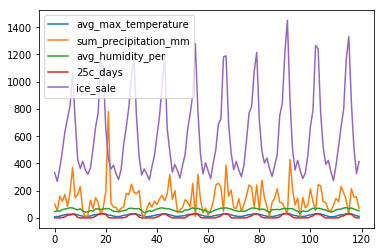

In [46]:
# year, month, avg_max_temperature, sum_precipitation_mm, avg_humidity_per, 25c_days, ice_sale
plt.plot(data['avg_max_temperature'], label='avg_max_temperature') # 最大気温平均
plt.plot(data['sum_precipitation_mm'], label='sum_precipitation_mm') # 合計降水量
plt.plot(data['avg_humidity_per'], label='avg_humidity_per') # 平均湿度
plt.plot(data['25c_days'], label='25c_days') # 25度以上の日数
plt.plot(data['ice_sale'], label='ice_sale') # アイスの売り上げ(円)
plt.legend()
plt.show()

In [52]:
# 最大気温平均, 合計降水量, 平均湿度, 25度以上の日数をもとに`アイスの売り上げ(円)`を予測します

temps = data['avg_max_temperature'].values.tolist() # 配列化
temps = np.array(temps).reshape((len(temps), 1)) # 形状変更 (120, 1)
print(temps.shape)

precs = data['sum_precipitation_mm'].values.tolist() # 配列化
precs = np.array(precs).reshape((len(precs), 1)) # 形状変更 (120, 1)
print(precs.shape)

up25days = data['25c_days'].values.tolist() # 配列化
up25days = np.array(up25days).reshape((len(up25days), 1)) # 形状変更 (120, 1)
print(up25days.shape)

icesales = data['ice_sale'].values.tolist() # 配列化
icesales = np.array(icesales).reshape((len(icesales), 1)) # 形状変更 (120, 1)
print(icesales.shape)

(120, 1)
(120, 1)
(120, 1)
(120, 1)


In [55]:
# 標準化
# すべての値を0~1の範囲に納める
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

normalized_temps = scaler.fit_transform(temps)
normalized_precs = scaler.fit_transform(precs)
normalized_up25days = scaler.fit_transform(up25days)
normalized_icesales = scaler.fit_transform(icesales)

/Users/t01530/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [61]:
normalized_icesales[0:10]

array([[ 0.05325444],
       [ 0.        ],
       [ 0.08199493],
       [ 0.18934911],
       [ 0.30769231],
       [ 0.39053254],
       [ 0.46745562],
       [ 0.66694844],
       [ 0.38546069],
       [ 0.13693998]])

In [67]:
temps_train_data, temps_train_label = create_reccurent_dataset(normalized_temps, step=5)
precs_train_data, precs_train_label = create_reccurent_dataset(normalized_precs, step=5)
up25days_train_data, up25days_train_label = create_reccurent_dataset(normalized_up25days, step=5)
icesales_train_data, icesales_train_label = create_reccurent_dataset(icesales, step=5)
print(temps_train_data.shape)
print(temps_train_label.shape)
print(precs_train_data.shape)
print(precs_train_label.shape)
print(up25days_train_data.shape)
print(up25days_train_label.shape)
print(icesales_train_data.shape)
print(icesales_train_label.shape)

(115, 5, 1)
(115, 1)
(115, 5, 1)
(115, 1)
(115, 5, 1)
(115, 1)
(115, 5, 1)
(115, 1)


In [ ]:
# pybitflyer データ取得

In [ ]:
import pybitflyer

In [ ]:
api = pybitflyer.API()
data = api.ticker(product_code='BTC_JPY')

In [ ]:
data

In [ ]:
print(data['ltp']) # 最終取引価格
print(data['best_ask']) # 最高買い価格
print(data['best_bid']) # 最小売り価格

In [ ]:
# 単変量のLSTM
# まずは最終取引価格だけで最終取引価格を予測

In [ ]:
import time
from datetime import datetime

In [ ]:
btc_jpy_data = []
count = 5
api = pybitflyer.API()
while True:
    tick = api.ticker(product_code='BTC_JPY')
    print('tick={} ltp={}'.format(len(btc_jpy_data), tick['ltp']))
    btc_jpy_data.append(tick)
    time.sleep(1)
    if count <= len(btc_jpy_data):
        break

In [ ]:
btc_jpy_data

In [36]:
# ファイルから
import json
with open('volume/datasets/BTC_JPY.json', 'r') as f:
    btc_jpy_data = json.load(f)

In [37]:
btc_jpy_data

[{'best_ask': 897424.0,
  'best_ask_size': 0.029,
  'best_bid': 897017.0,
  'best_bid_size': 0.11,
  'ltp': 897000.0,
  'product_code': 'BTC_JPY',
  'tick_id': 1186212,
  'timestamp': '2018-03-23T08:35:20.193',
  'total_ask_depth': 3475.01529271,
  'total_bid_depth': 2803.02460289,
  'volume': 326761.02232169,
  'volume_by_product': 24793.72478289},
 {'best_ask': 897432.0,
  'best_ask_size': 0.11,
  'best_bid': 897017.0,
  'best_bid_size': 0.11,
  'ltp': 897433.0,
  'product_code': 'BTC_JPY',
  'tick_id': 1186243,
  'timestamp': '2018-03-23T08:35:20.96',
  'total_ask_depth': 3474.52468581,
  'total_bid_depth': 2799.54078582,
  'volume': 326761.4647674,
  'volume_by_product': 24793.8057286},
 {'best_ask': 897432.0,
  'best_ask_size': 0.11,
  'best_bid': 897019.0,
  'best_bid_size': 0.1270288,
  'ltp': 897433.0,
  'product_code': 'BTC_JPY',
  'tick_id': 1186277,
  'timestamp': '2018-03-23T08:35:21.757',
  'total_ask_depth': 3475.31701136,
  'total_bid_depth': 2813.92036842,
  'volume': 3

In [38]:
# ltpだけ利用
data = [[d['ltp']] for d in btc_jpy_data]

In [39]:
data

[[897000.0],
 [897433.0],
 [897433.0],
 [897019.0],
 [897001.0],
 [897403.0],
 [897403.0],
 [897392.0],
 [897392.0],
 [897371.0],
 [897371.0],
 [897371.0],
 [897363.0],
 [897371.0],
 [897363.0],
 [897363.0],
 [897343.0],
 [897350.0],
 [897350.0],
 [897341.0],
 [897351.0],
 [897351.0],
 [897351.0],
 [897351.0],
 [897351.0],
 [896437.0],
 [897007.0],
 [896437.0],
 [897382.0],
 [897374.0],
 [897374.0],
 [897345.0],
 [897345.0],
 [897330.0],
 [897330.0],
 [897329.0],
 [897329.0],
 [897345.0],
 [897344.0],
 [897334.0],
 [897333.0],
 [897333.0],
 [897329.0],
 [897329.0],
 [897325.0],
 [897321.0],
 [897320.0],
 [897319.0],
 [897317.0],
 [896182.0],
 [897200.0],
 [897200.0],
 [896114.0],
 [897187.0],
 [897196.0],
 [897195.0],
 [897194.0],
 [897193.0],
 [897200.0],
 [897196.0],
 [897196.0],
 [897190.0],
 [897190.0],
 [897190.0],
 [897185.0],
 [897185.0],
 [897183.0],
 [897183.0],
 [897183.0],
 [897199.0],
 [897199.0],
 [897200.0],
 [897200.0],
 [897200.0],
 [897200.0],
 [897099.0],
 [897099.0],

In [ ]:
plt.figure()
plt.plot(range(0, len(data)), data, color='r', label='data')
plt.legend()
plt.show()

In [ ]:
# 標準化
# すべての値を0~1の範囲に納める
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(data)
print(normalized_data)

In [ ]:
train_data, train_label = create_reccurent_dataset(normalized_data, step=5)
print(train_data.shape)
print(train_label.shape)

In [ ]:
# モデル構築
# 学習率の調整がキモ?? 0.00001だと200stepでも不安定、0.0001なら50step程度でEarlyStoppingする
step_count = 5
feature_count = 1
hidden_unit_count = 300
model = Sequential()
model.add(LSTM(hidden_unit_count, batch_input_shape=(None, step_count, feature_count), return_sequences=False))
model.add(Dense(1))
model.add(Activation('linear'))
optimizer = Adam(lr=0.0001) # 学習率 0.001 -> 0.003 -> 0.03 -> 0.01
model.compile(loss='mean_squared_error', optimizer=optimizer)
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=0)

In [ ]:
# トレーニング
model.fit(
    train_data, train_label,
    batch_size=2000,
    epochs=200,
    validation_split=0.1,
    callbacks=[early_stopping]
)

In [ ]:
model.predict(np.array([[[1.0],[0.8],[0.6],[0.4],[0.2]]]))[0][0]

In [ ]:
model.predict(np.array([[[0.0],[0.0],[0.0],[0.0],[0.0]]]))[0][0]

In [ ]:
model.predict(np.array([[[1.0],[1.0],[1.0],[1.0],[1.0]]]))[0][0]

In [ ]:
model.predict(np.array([[[0.2],[0.4],[0.6],[0.8],[1.0]]]))[0][0]

In [ ]:
# 推論、検証
predictions = model.predict(train_data)

In [ ]:
plt.figure()
plt.plot(range(0, len(predictions)), predictions, color='r', label='predictions')
plt.plot(range(0, len(train_label)), train_label, color='b', label='train_label')
plt.legend()
plt.show()

In [ ]:
# 未来予測
latest_data = train_data[len(train_data)-1]
results = np.empty((0, 0))
for _ in range(50):
    # 推論
    test_data = np.reshape(latest_data, (1, 5, 1))
    batch_predict = model.predict(test_data)
    # 結果蓄積
    results = np.append(results, batch_predict)
    # 次のデータをセット
    latest_data = np.delete(latest_data, 0)
    latest_data = np.append(latest_data, batch_predict)

# (個数)から(個数,1)に形状を変える
results = np.reshape(results, (results.shape[0], 1))

In [ ]:
plt.figure()
plt.plot(range(0, len(predictions)), predictions, color='r', label='predictions')
plt.plot(range(0, len(train_label)), train_label, color='b', label='train_label')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results, color='g', label='future_predictions')
plt.legend()
plt.show()

In [ ]:
# 多変量のLSTM
# 利用する特徴 ltp, best_ask, best_bid

In [ ]:
ltp_data = np.array([[d['ltp']] for d in btc_jpy_data])
best_ask_data = np.array([[d['best_ask']] for d in btc_jpy_data])
best_bid_data = np.array([[d['best_bid']] for d in btc_jpy_data])

In [ ]:
# 標準化
scaler = MinMaxScaler(feature_range=(0, 1))
ltp_data = scaler.fit_transform(ltp_data)
best_ask_data = scaler.fit_transform(best_ask_data)
best_bid_data = scaler.fit_transform(best_bid_data)

In [ ]:
plt.figure()
plt.plot(range(0, len(ltp_data)), ltp_data, color='r', label='ltp')
plt.plot(range(0, len(best_ask_data)), best_ask_data, color='g', label='best_ask')
plt.plot(range(0, len(best_bid_data)), best_bid_data, color='b', label='best_bid')
plt.legend()
plt.show()

In [ ]:
ltp_train_data, ltp_train_label = create_reccurent_dataset(ltp_data, step=5)
best_ask_train_data, best_ask_train_label = create_reccurent_dataset(best_ask_data, step=5)
best_bid_train_data, best_bid_train_label = create_reccurent_dataset(best_bid_data, step=5)

In [ ]:
print(ltp_train_data.shape)
print(best_ask_train_data.shape)
print(best_bid_train_data.shape)

In [ ]:
print(ltp_train_label.shape)
print(best_ask_train_label.shape)
print(best_bid_train_label.shape)

In [ ]:
# 推論する際の形状 = (個数, ステップ数, 特徴量)
# 前回の推論時の形状 = (個数, 5, 1)
# 今回の推論時の形状 = (個数, 5, 3)
# 入力も出力もltp, best_ask, best_bidの3つ
train_data = np.c_[ltp_train_data, best_ask_train_data, best_bid_train_data]
train_label = np.c_[ltp_train_label, best_ask_train_label, best_bid_train_label]
print(train_data.shape)
print(train_label.shape)

In [ ]:
# モデル構築
step_count = 5
feature_count = 3
hidden_unit_count = 300

model = Sequential()
model.add(LSTM(hidden_unit_count, batch_input_shape=(None, step_count, feature_count), return_sequences=False))
model.add(Dense(3))
model.add(Activation('linear'))
optimizer = Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)

In [ ]:
# トレーニング
model.fit(
    train_data, train_label,
    batch_size=2000,
    epochs=200,
    validation_split=0.1,
    callbacks=[early_stopping]
)

In [ ]:
# 推論、検証
predictions = model.predict(train_data)

In [ ]:
plt.figure()
plt.plot(range(0, len(train_label)), train_label[:,0], color=(1.0, 0.7, 0.7), label='train_label ltp')
plt.plot(range(0, len(train_label)), train_label[:,1], color=(0.7, 1.0, 0.7), label='train_label best_ask')
plt.plot(range(0, len(train_label)), train_label[:,2], color=(0.7, 0.7, 1.0), label='train_label best_bid')
plt.plot(range(0, len(predictions)), predictions[:,0], color=(1.0, 0.0, 0.0), label='predictions ltp')
plt.plot(range(0, len(predictions)), predictions[:,1], color=(0.0, 1.0, 0.0), label='predictions best_ask')
plt.plot(range(0, len(predictions)), predictions[:,2], color=(0.0, 0.0, 1.0), label='predictions best_bid')
plt.legend()
plt.show()

In [ ]:
latest_data = np.array([train_data[len(train_data)-1]])
results = []
for _ in range(50):
    # 推論
    batch_predict = model.predict(latest_data)
    # 結果蓄積
    results.append([batch_predict[0][0], batch_predict[0][1], batch_predict[0][2]])
    # 次のデータをセット
    latest_data = np.delete(latest_data, np.array([batch_predict]), axis=1)
    latest_data = np.append(latest_data, np.array([batch_predict]), axis=1)
results = np.array(results)
results.shape

In [ ]:
plt.figure()
plt.plot(range(0, len(train_label)), train_label[:,0], color=(1.0, 0.7, 0.7), label='train_label ltp')
plt.plot(range(0, len(train_label)), train_label[:,1], color=(0.7, 1.0, 0.7), label='train_label best_ask')
plt.plot(range(0, len(train_label)), train_label[:,2], color=(0.7, 0.7, 1.0), label='train_label best_bid')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results[:,0], color=(1.0, 0.0, 0.0), label='future ltp')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results[:,1], color=(0.0, 1.0, 0.0), label='future best_ask')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results[:,2], color=(0.0, 0.0, 1.0), label='future best_bid')
plt.legend()
plt.show()

In [ ]:
# TODO: リアルタイム予測 and 学習
# 特徴量を増やすと良いかもしれない 最大、最小、ローソク足の最大最小、関連ニュース数(良し悪し別)、曜日

In [ ]:
# TODO: RNN  word2vec